In [1]:
import regex as re
import numpy as np
from statistics import mean, stdev
import matplotlib
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#from bento_bench import bar_plot, parse_elapsed_secs, get_avg_from_table_str, set_size
import pandas as pd
import json
import os
import seaborn as sns
import dpfs
from dpfs import *
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    #"pgf.texsystem": "pdflatex",
    "font.family": "serif",
    #"font.serif": 'DejaVu Serif',
    #'text.usetex': False,
#     'pgf.rcfonts': False,
    "font.size": 18,
    #"font.weight": "bold",
    'ps.useafm': True,
    "pdf.use14corefonts": True,
    "text.usetex": True,
})

TARGET = "./thesis/"
OUT = TARGET + "/out/"

In [2]:
# DPFS-NULL-pre (including MP)
df = parse_fio(["randread", "randwrite"], ["4k", "16k", "64k"],
               ["1", "2", "4", "8", "16", "32", "64", '128'],
               ["1", "2", "4", "8"], "DPFS-NULL-pre", TARGET+"/DPFS-NULL-pre/")

# DPFS-NFS-pre
s = parse_fio(["randread", "randwrite"], ["4k", "16k", "64k"],
               ["1", "2", "4", "8", "16", "32", "64", '128'],
               ["1"], "DPFS-NFS-pre", TARGET+"/DPFS-NFS-pre/")
df = pd.concat((s, df), ignore_index=True)

# DPFS-NFS-post
s = parse_fio(["randread", "randwrite"], ["4k", "16k", "64k"],
               ["1", "2", "4", "8", "16", "32", "64", '128'],
               ["1"], "DPFS-NFS-post", TARGET+"/DPFS-NFS-post/")
df = pd.concat((s, df), ignore_index=True)

# DPFS-URING-tmpfs-waiting
s = parse_fio(["randread", "randwrite"], ["4k", "16k", "64k"],
               ["1", "2", "4", "8", "16", "32", "64", '128'],
               ["1"], "DPFS-URING-tmpfs-waiting", TARGET+"/DPFS-URING-tmpfs-waiting/")
df = pd.concat((s, df), ignore_index=True)

# DPFS-NFS-post
s = parse_fio(["randread", "randwrite"], ["4k", "16k", "64k"],
               ["1", "2", "4", "8", "16", "32", "64", '128'],
               ["1"], "DPFS-URING-tmpfs-polling", TARGET+"/DPFS-URING-tmpfs-polling/")
df = pd.concat((s, df), ignore_index=True)

print(df)

                         conf         RW   BS   QD  P   IOPS_avg  IOPS_stdev  \
0    DPFS-URING-tmpfs-polling   randread   4k    1  1   21856.48      101.20   
1    DPFS-URING-tmpfs-polling   randread   4k    2  1   47635.17      258.32   
2    DPFS-URING-tmpfs-polling   randread   4k    4  1   78251.98      357.39   
3    DPFS-URING-tmpfs-polling   randread   4k    8  1  112390.21      238.80   
4    DPFS-URING-tmpfs-polling   randread   4k   16  1  130926.12      877.18   
..                        ...        ...  ...  ... ..        ...         ...   
379             DPFS-NULL-pre  randwrite  64k   64  8   72332.77     2983.79   
380             DPFS-NULL-pre  randwrite  64k  128  1   74351.35      342.55   
381             DPFS-NULL-pre  randwrite  64k  128  2   74048.97     2990.56   
382             DPFS-NULL-pre  randwrite  64k  128  4   73392.82     3585.12   
383             DPFS-NULL-pre  randwrite  64k  128  8   74422.38     5596.76   

     clat_avg  clat_stdev       bw_avg 

In [3]:
df_clat = parse_fio_clat(["randread", "randwrite"], ["4k"], ["16", "128"], ["1"], "DPFS-NFS-pre", TARGET+"/DPFS-NFS-pre/")

s = parse_fio_clat(["randread", "randwrite"], ["4k"], ["16", "128"], ["1"], "DPFS-NFS-post", TARGET+"/DPFS-NFS-post/")
df_clat = pd.concat((s, df_clat), ignore_index=True)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



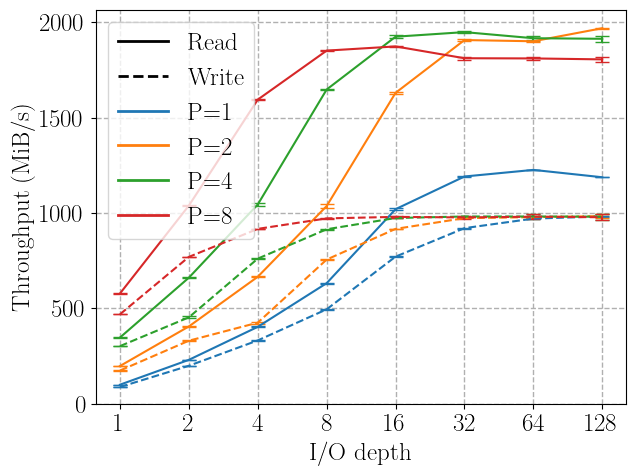

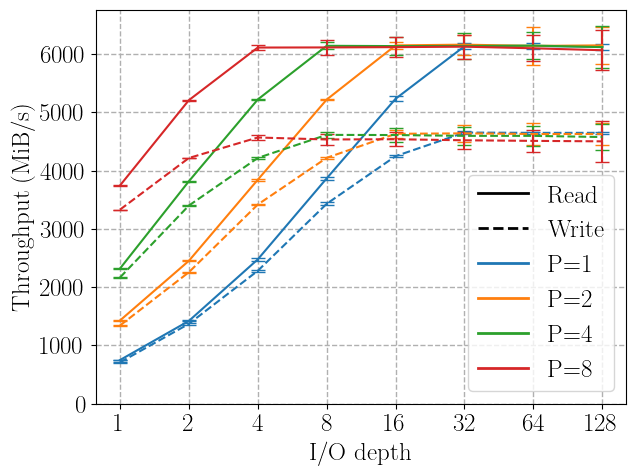

In [4]:
# Experiment 0.1
plot_tp(df, {'DPFS-NULL-pre': 'DPFS-NULL'}, ['4k'], ['1', '2', '4', '8'],
             None, None, {'1': 'tab:blue', '2': 'tab:orange', '4': 'tab:green', '8': 'tab:red'},
             False, OUT+"/DPFS-NULL-pre-mp-4k.pdf")
plot_tp(df, {'DPFS-NULL-pre': 'DPFS-NULL'}, ['64k'], ['1', '2', '4', '8'],
             None, None, {'1': 'tab:blue', '2': 'tab:orange', '4': 'tab:green', '8': 'tab:red'},
             False, OUT+"/DPFS-NULL-pre-mp-64k.pdf")

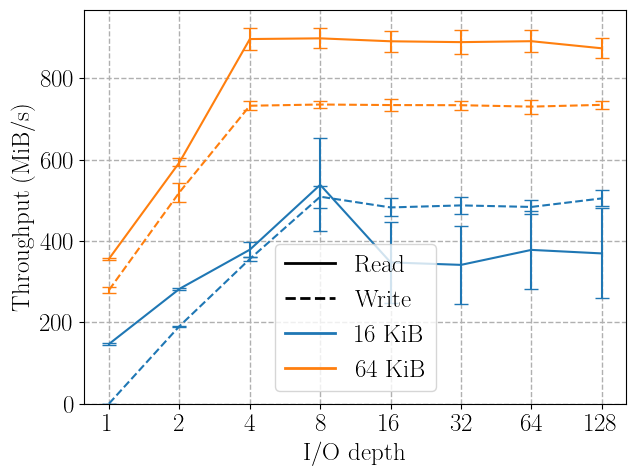

In [13]:
# Experiment 0.2
plot_tp(df, {'DPFS-NFS-pre': 'DPFS-NFS'}, ['16k', '64k'], ['1'],
             None, {'16k': 'tab:blue', '64k': 'tab:orange'}, None,
             False, OUT+"/DPFS-NFS-pre-largebs.pdf")

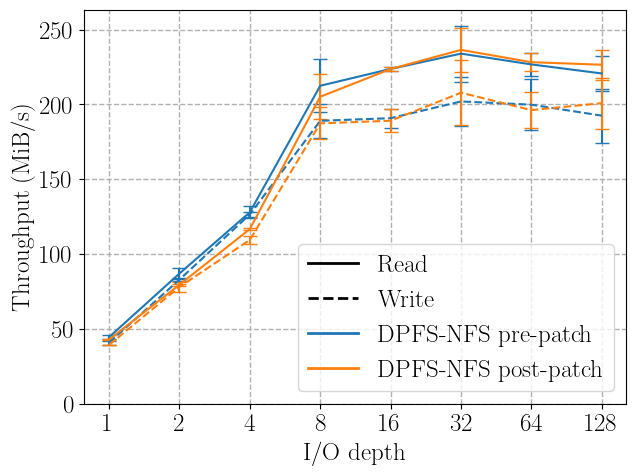

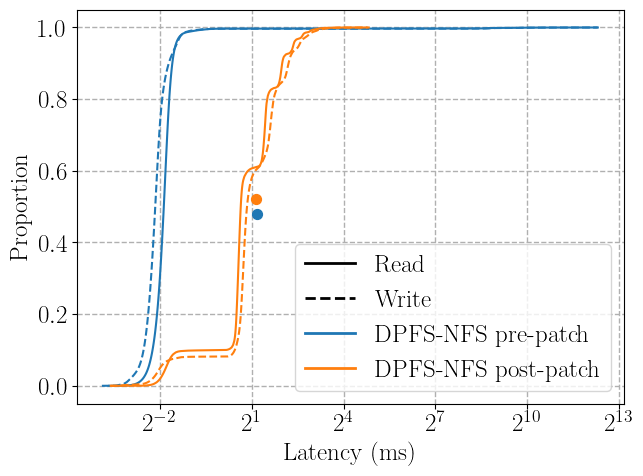

In [8]:
# Experiment 1.1
plot_tp(df, {'DPFS-NFS-pre': 'DPFS-NFS pre-patch ', 'DPFS-NFS-post': 'DPFS-NFS post-patch '},
        ['4k'], ['1'],
        {'DPFS-NFS-pre': 'tab:blue', 'DPFS-NFS-post': 'tab:orange'}, None, None,
        False, OUT+"/DPFS-NFS-patch_tp.pdf")
# Experiment 1.2
plot_cdf(df_clat, {'DPFS-NFS-pre': 'DPFS-NFS pre-patch ', 'DPFS-NFS-post': 'DPFS-NFS post-patch '},
        ["randread", "randwrite"], "4k", "128", "1",
        {'DPFS-NFS-pre': 'tab:blue', 'DPFS-NFS-post': 'tab:orange'}, OUT+"/DPFS-NFS-patch_cdf.pdf")

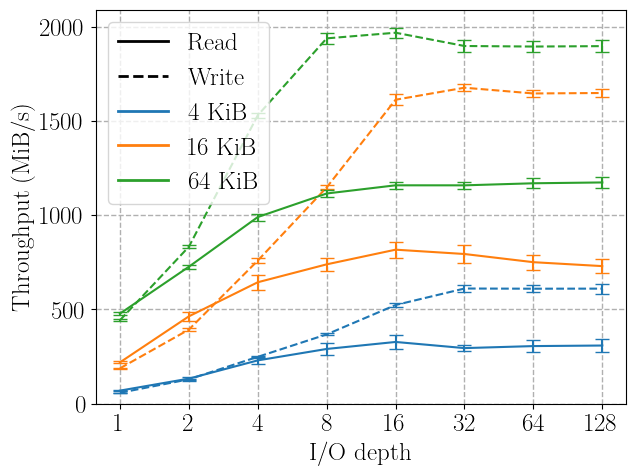

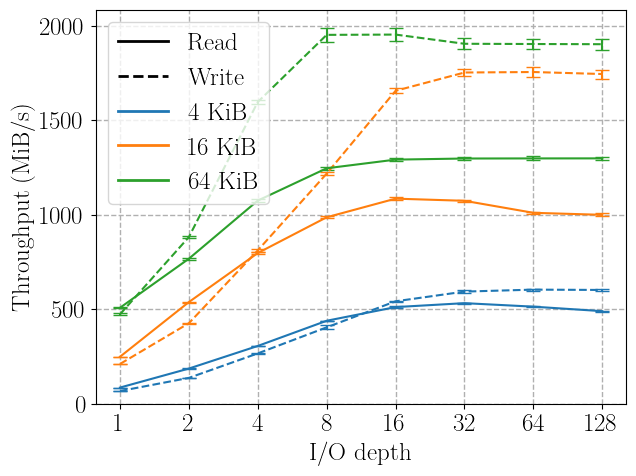

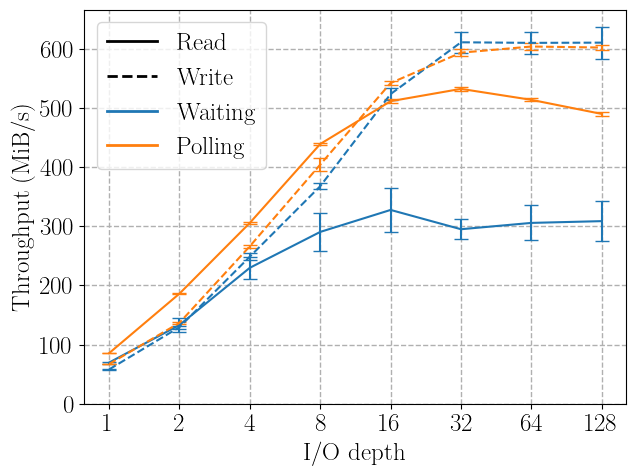

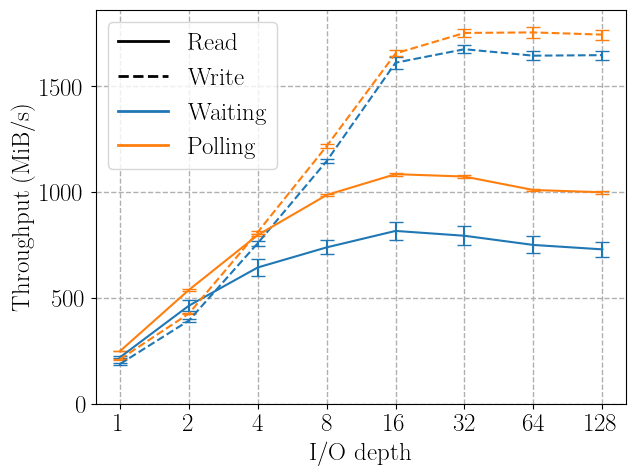

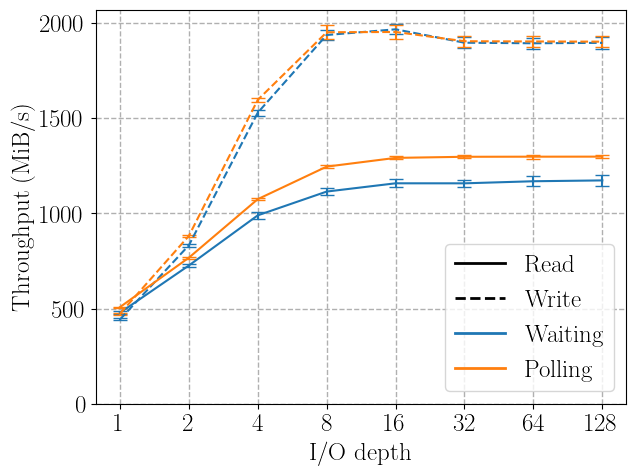

In [12]:
# Experiment 2.1
plot_tp(df, {'DPFS-URING-tmpfs-waiting': 'DPFS-KERNEL + tmpfs (waiting)'},
        ['4k', '16k', '64k'], ['1'],
        None, {'4k': 'tab:blue', '16k': 'tab:orange', '64k': 'tab:green'}, None,
        False, OUT+"/DPFS-URING-tmpfs-waiting_tp.pdf")

plot_tp(df, {'DPFS-URING-tmpfs-polling': 'DPFS-KERNEL + tmpfs (polling)'},
        ['4k', '16k', '64k'], ['1'],
        None, {'4k': 'tab:blue', '16k': 'tab:orange', '64k': 'tab:green'}, None,
        False, OUT+"/DPFS-URING-tmpfs-polling_tp.pdf")

plot_tp(df, {'DPFS-URING-tmpfs-waiting': 'Waiting', 'DPFS-URING-tmpfs-polling': 'Polling'},
             ['4k'], ['1'],
             {'DPFS-URING-tmpfs-waiting': 'tab:blue', 'DPFS-URING-tmpfs-polling': 'tab:orange'}, None, None,
             False, OUT+"/DPFS-URING-tmpfs-4k_tp.pdf")

plot_tp(df, {'DPFS-URING-tmpfs-waiting': 'Waiting', 'DPFS-URING-tmpfs-polling': 'Polling'},
             ['16k'], ['1'],
             {'DPFS-URING-tmpfs-waiting': 'tab:blue', 'DPFS-URING-tmpfs-polling': 'tab:orange'}, None, None,
             False, OUT+"/DPFS-URING-tmpfs-16k_tp.pdf")

plot_tp(df, {'DPFS-URING-tmpfs-waiting': 'Waiting', 'DPFS-URING-tmpfs-polling': 'Polling'},
             ['64k'], ['1'],
             {'DPFS-URING-tmpfs-waiting': 'tab:blue', 'DPFS-URING-tmpfs-polling': 'tab:orange'}, None, None,
             False, OUT+"/DPFS-URING-tmpfs-64k_tp.pdf")